# Import lib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
import datetime
import rich
import cProfile
from util.logger.logger import logger
import warnings
# logger=logger.opt(colors=True)

# with data 'data/sales_data_sample.xlsx

Source: https://www.marktechpost.com/2025/04/11/complete-guide-working-with-csv-excel-files-and-eda-in-python/?ref=dailydev

Our sample dataset represents an e-commerce company’s sales data. It contains five sheets:

Sales_Data: Main transactional data with 1,000 orders

Customer_Data: Customer demographic information

Inventory: Product inventory details

Monthly_Summary: Pre-aggregated monthly sales data

Data_Issues: A sample of data with intentional quality problems for practice

'''
Sales_Data: Dữ liệu giao dịch chính với 1.000 đơn hàng

Customer_Data: Thông tin nhân khẩu học của khách hàng

Inventory: Chi tiết hàng tồn kho sản phẩm

Monthly_Summary: Dữ liệu bán hàng hàng tháng được tổng hợp trước

Data_Issues: Một mẫu dữ liệu có vấn đề về chất lượng cố ý để thực hành
'''

In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")


In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.precision", 2)

In [ ]:
file_name = "/home/user/pandas-polar-dask/data/_1_bronze data/sales_data_sample.xlsx"

In [ ]:
excel_file = pd.ExcelFile(file_name)
sheet_names = excel_file.sheet_names
sheet_names

In [ ]:
@logger.catch
def read_all_sheets():
    all_dfs = {}
    for sheet in sheet_names:
        all_dfs[sheet] = pd.read_excel(excel_file, sheet_name=sheet)
        logger.opt(colors=True).info(
            f"<green>Load sheet {sheet} with shape {all_dfs[sheet].shape}</green>"
        )
    return all_dfs


all_dfs = read_all_sheets()

In [ ]:
all_dfs["Sales_Data"]["Order_ID"].nunique() - all_dfs["Sales_Data"].shape[0]

## process Data_Issues

In [37]:
# Data_Issues
df_dataIssues = all_dfs["Data_Issues"]
df_dataIssues.head()

,Order_ID,Date,Category,Region,Customer_Segment,Payment_Method,Quantity,Unit_Price,Discount_Rate,Customer_Rating,Returned,Subcategory,Total_Price,Discount_Amount,Net_Sales,Shipping_Cost,Profit_Margin,Profit,Month
0,ORD-10049,1970-01-01 07:30:46,Sports,Central,New,Debit Card,2.0,441.08,0.05,1.0,False,Winter Sports,882.16,44.11,838.05,0.00,0.25,209.51,2025-02
1,ORD-10518,1970-01-01 07:30:46,Electronics,Central,Regular,PayPal,1.0,270.91,0.10,4.0,False,Laptops,270.91,27.09,243.82,0.00,0.28,68.27,2025-01
2,ORD-10726,1970-01-01 07:30:46,Electronics,South,Business,PayPal,9.0,190.44,0.10,3.0,False,Audio,1713.96,171.40,1542.56,0.00,0.40,617.03,2024-11
3,ORD-10443,1970-01-01 07:30:46,Sports,West,Business,Debit Card,2.0,184.92,0.10,4.0,False,Outdoor,369.84,36.98,332.86,0.00,0.30,99.86,2024-08
4,ORD-10928,1970-01-01 07:30:45,Clothing,East,New,Debit Card,1.0,116.62,0.05,4.0,False,Men,116.62,5.83,110.79,18.27,0.35,38.78,2024-07


In [38]:
df_dataIssues.isna().sum()

Order_ID             0
Date                 5
Category             5
Region              10
Customer_Segment     0
Payment_Method       0
Quantity             5
Unit_Price           0
Discount_Rate        2
Customer_Rating      5
Returned             0
Subcategory          0
Total_Price          0
Discount_Amount      0
Net_Sales            0
Shipping_Cost        3
Profit_Margin        0
Profit               0
Month                0
dtype: int64

In [39]:
df_dataIssues[df_dataIssues["Quantity"] <= 0]

,Order_ID,Date,Category,Region,Customer_Segment,Payment_Method,Quantity,Unit_Price,Discount_Rate,Customer_Rating,Returned,Subcategory,Total_Price,Discount_Amount,Net_Sales,Shipping_Cost,Profit_Margin,Profit,Month


In [40]:
df_dataIssues["Region"].unique()

array(['Central', 'South', 'West', 'East', nan, 'North'], dtype=object)

### Clear data

In [41]:
df_dataIssues_cleaned = (
    df_dataIssues.copy(deep=True)
)  # deep copy a df to avoid modified origin df


In [42]:
df_dataIssues_cleaned["Date"].unique()

<DatetimeArray>
['1970-01-01 07:30:46', '1970-01-01 07:30:45', 'NaT']
Length: 3, dtype: datetime64[ns]

In [43]:
# Process datetime, because datetime has missing values (5)
# Date is important field
# transfer to datetime type, error = coerce: ignore error, fill NaT if can not convert to datetime
df_dataIssues_cleaned["Date"] = pd.to_datetime(df_dataIssues_cleaned["Date"], errors="coerce", format="%Y-%m-%d %H:%M:%S")

# df_dataIssues_cleaned["Date"].apply(
#     lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
# )

In [45]:
# median()
date_median = df_dataIssues_cleaned["Date"].median()
date_median

Timestamp('1970-01-01 07:30:46')

In [46]:
df_dataIssues_cleaned["Date"].fillna(date_median, inplace=True)

In [47]:
df_dataIssues_cleaned["Category"].fillna("Unknown", inplace=True)

In [48]:
df_dataIssues_cleaned["Quantity"] = df_dataIssues_cleaned["Quantity"].abs()

In [49]:
df_dataIssues_cleaned["Region"] = df_dataIssues_cleaned[
    "Region"
].str.title()  # first letter per word uppercase
df_dataIssues_cleaned["Region"].unique()

array(['Central', 'South', 'West', 'East', nan, 'North'], dtype=object)

In [50]:
# Recalculate derived fields
df_dataIssues_cleaned["Total_Price"] = (
    df_dataIssues_cleaned["Quantity"] * df_dataIssues_cleaned["Unit_Price"]
)
logger.info(df_dataIssues_cleaned["Total_Price"].head())


2025-08-30 18:15:22.144 | INFO     | __main__:<module>:5 - 0     882.16
1     270.91
2    1713.96
3     369.84
4     116.62
Name: Total_Price, dtype: float64


In [51]:
df_dataIssues_cleaned["Discount_Amount"] = (
    df_dataIssues_cleaned["Total_Price"] * df_dataIssues_cleaned["Discount_Rate"]
)
df_dataIssues_cleaned["Discount_Amount"].head()

0     44.11
1     27.09
2    171.40
3     36.98
4      5.83
Name: Discount_Amount, dtype: float64

In [52]:
df_dataIssues_cleaned["Net_Sales"] = (
    df_dataIssues_cleaned["Total_Price"] - df_dataIssues_cleaned["Discount_Amount"]
)
df_dataIssues_cleaned["Net_Sales"].head()

0     838.05
1     243.82
2    1542.56
3     332.86
4     110.79
Name: Net_Sales, dtype: float64

In [54]:
all_dfs["Sales_Data"]["Date"].copy(deep=True).head()

0   1970-01-01 07:30:45
1   1970-01-01 07:30:46
2   1970-01-01 07:30:46
3   1970-01-01 07:30:45
4   1970-01-01 07:30:45
Name: Date, dtype: datetime64[ns]

In [58]:
import pandas as pd
import numpy as np

def random_date(n: int = 10, datetime_format: str = "%Y-%m-%d %H:%M:%S"):
   # Define start and end date
   start_date = pd.to_datetime("2024-01-01 00:00:00")
   end_date = pd.to_datetime("2025-01-01 00:00:00")

   # Generate random timestamps
   random_dates = start_date + (end_date - start_date) * np.random.rand(n)

   # Convert to pandas DatetimeIndex (optional)
   random_dates = pd.to_datetime(random_dates, errors="coerce", format=datetime_format)
   return random_dates
#    print(random_dates)
random_date(n = 10)

DatetimeIndex(['2024-02-28 19:17:44.851906873',
               '2024-04-11 04:06:40.279390801',
               '2024-10-07 22:59:22.043517292',
               '2024-03-16 10:12:51.645129981',
               '2024-12-22 12:34:13.976241072',
               '2024-08-23 09:21:35.209796888',
               '2024-05-25 13:01:32.491363180',
               '2024-08-31 22:47:08.169502568',
               '2024-06-16 00:20:36.452355544',
               '2024-12-28 20:24:32.381615696'],
              dtype='datetime64[ns]', freq=None)

In [59]:
sales_df = all_dfs["Sales_Data"].copy(deep=True)
# Clean the main sales data
# change here, due to in data, just 1 value: 1/1/1970
sales_df["Date"] = random_date(sales_df.shape[0])
# 1. Convert date column to datetime
# sales_df["Date"] = pd.to_datetime(sales_df["Date"])
# 2. Handle missing values in Customer_Rating, Shipping_Cost, and Discount_Rate
sales_df["Customer_Rating"].fillna(sales_df["Customer_Rating"].median(), inplace=True)
sales_df["Shipping_Cost"].fillna(sales_df["Shipping_Cost"].mean(), inplace=True)
sales_df["Discount_Rate"].fillna(0, inplace=True)  # Assume no discount if missing
# 3. Create new date-related columns
sales_df["Year"] = sales_df["Date"].dt.year
sales_df["Month"] = sales_df["Date"].dt.month
sales_df["Day"] = sales_df["Date"].dt.day
sales_df["DayOfWeek"] = sales_df["Date"].dt.day_name()
sales_df["WeekOfYear"] = sales_df["Date"].dt.isocalendar().week
logger.info(
    f"Cleaned sales data with new date columns:\n{sales_df[['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear']].head()}"
)

2025-08-30 18:19:52.881 | INFO     | __main__:<module>:17 - Cleaned sales data with new date columns:
                           Date  Year  Month  Day  DayOfWeek  WeekOfYear
0 2024-02-08 18:34:13.077410312  2024      2    8   Thursday           6
1 2024-10-07 10:33:01.033598332  2024     10    7     Monday          41
2 2024-04-28 02:49:03.137408860  2024      4   28     Sunday          17
3 2024-05-29 19:31:27.189540680  2024      5   29  Wednesday          22
4 2024-09-15 06:43:38.505119780  2024      9   15     Sunday          37


In [60]:
sales_df["DayOfWeek"]

0       Thursday
1         Monday
2         Sunday
3      Wednesday
4         Sunday
         ...    
995      Tuesday
996       Friday
997       Sunday
998       Friday
999     Thursday
Name: DayOfWeek, Length: 1000, dtype: object

In [61]:
sales_df["Date"].unique()

<DatetimeArray>
['2024-02-08 18:34:13.077410312', '2024-10-07 10:33:01.033598332',
 '2024-04-28 02:49:03.137408860', '2024-05-29 19:31:27.189540680',
 '2024-09-15 06:43:38.505119780', '2024-09-05 22:28:49.392199080',
 '2024-08-16 07:13:20.659740672', '2024-05-05 23:48:48.409257982',
 '2024-06-27 06:32:21.026032586', '2024-06-19 20:12:53.984825406',
 ...
 '2024-12-02 14:24:33.982663576', '2024-11-16 09:11:21.128601096',
 '2024-12-24 09:57:06.741629652', '2024-02-04 18:45:49.956238046',
 '2024-11-23 23:18:50.848135352', '2024-07-16 02:21:20.263101390',
 '2024-12-13 07:00:55.475380576', '2024-07-07 11:14:35.719522450',
 '2024-02-16 15:32:40.117101178', '2024-12-26 21:03:53.642338764']
Length: 1000, dtype: datetime64[ns]

In [62]:
# Get customer and sales data
customer_df = all_dfs["Customer_Data"]
# Merge sales and customer data
sales_customer = pd.merge(sales_df, customer_df, on="Order_ID", how="left")
print("Merged sales and customer data:")
print(sales_customer.shape)
print(sales_customer.head())
# Check if all sales records have corresponding customer data
missing_customer_data = sales_customer[sales_customer["Customer_ID"].isna()]
print(f"\nNumber of sales records without customer data: {len(missing_customer_data)}")

Merged sales and customer data:
(1000, 30)
    Order_ID                          Date        Category   Region Customer_Segment Payment_Method  Quantity  Unit_Price  Discount_Rate  Customer_Rating  Returned   Subcategory  Total_Price  Discount_Amount  Net_Sales  Shipping_Cost  Profit_Margin   Profit  Month  Year  Day  DayOfWeek  WeekOfYear Customer_ID Age_Group  Gender        Member_Since   Device  Browser  First_Purchase
0  ORD-10000 2024-02-08 18:34:13.077410312           Books     East         Business         PayPal         1      316.58           0.20              5.0     False        Comics       316.58            63.32     253.26            0.0           0.33    83.58      2  2024    8   Thursday           6   CUST-1430     35-44  Female 1970-01-01 07:30:45   Mobile  Firefox           False
1  ORD-10001 2024-10-07 10:33:01.033598332          Sports     West          Premium  Bank Transfer         5      279.76           0.10              4.0      True  Water Sports      1398.80 

In [63]:
sales_customer.columns

Index(['Order_ID', 'Date', 'Category', 'Region', 'Customer_Segment',
       'Payment_Method', 'Quantity', 'Unit_Price', 'Discount_Rate',
       'Customer_Rating', 'Returned', 'Subcategory', 'Total_Price',
       'Discount_Amount', 'Net_Sales', 'Shipping_Cost', 'Profit_Margin',
       'Profit', 'Month', 'Year', 'Day', 'DayOfWeek', 'WeekOfYear',
       'Customer_ID', 'Age_Group', 'Gender', 'Member_Since', 'Device',
       'Browser', 'First_Purchase'],
      dtype='object')

In [64]:
# Get inventory data
inventory_df = all_dfs["Inventory"]
inventory_df.head()

,Product_ID,Product_Name,Category,Subcategory,Price,Cost,Stock_Level,Reorder_Level,Supplier,Lead_Time_Days,Last_Restocked
0,PROD-1000,Smartphones Item 1,Electronics,Smartphones,167.05,104.88,193,30,Supplier C,11,1970-01-01 07:30:46
1,PROD-1001,Smartphones Item 2,Electronics,Smartphones,170.09,104.00,53,35,Supplier A,2,1970-01-01 07:30:46
2,PROD-1002,Smartphones Item 3,Electronics,Smartphones,441.11,343.22,86,23,Supplier A,25,1970-01-01 07:30:46
3,PROD-1003,Smartphones Item 4,Electronics,Smartphones,426.65,244.25,174,20,Supplier A,10,1970-01-01 07:30:45
4,PROD-1004,Smartphones Item 5,Electronics,Smartphones,232.08,155.88,61,23,Supplier C,17,1970-01-01 07:30:45


In [65]:
# First, we need to create a common key to join on Sales_Data and Inventory
# Since we don't have product IDs in the sales data, we'll join on Category and Subcategory
# This isn't ideal in a real scenario but works for our demo
# Create product metrics at the category-subcategory level
product_sales = (
    sales_df.groupby(["Category", "Subcategory"])
    .agg({"Net_Sales": "sum", "Quantity": "sum", "Order_ID": "count", "Profit": "sum"})
    .reset_index()
)
product_sales.rename(columns={"Order_ID": "Orders"}, inplace=True)
product_sales.head()

,Category,Subcategory,Net_Sales,Quantity,Orders,Profit
0,Books,Children,51895.67,186,33,14978.51
1,Books,Comics,51517.57,213,41,14212.91
2,Books,Educational,53282.67,214,42,16824.27
3,Books,Fiction,56516.28,212,36,18218.01
4,Books,Non-fiction,30863.05,158,34,9810.64


In [66]:
# Merge with inventory aggregates
inventory_agg = (
    inventory_df.groupby(["Category", "Subcategory"])
    .agg(
        {"Stock_Level": "sum", "Reorder_Level": "sum", "Price": "mean", "Cost": "mean"}
    )
    .reset_index()
)
product_inventory = pd.merge(
    product_sales, inventory_agg, on=["Category", "Subcategory"], how="left"
)
print("Product sales with inventory data:")
print(product_inventory.head())

Product sales with inventory data:
  Category  Subcategory  Net_Sales  Quantity  Orders    Profit  Stock_Level  Reorder_Level   Price    Cost
0    Books     Children   51895.67       186      33  14978.51          509            140  270.72  166.76
1    Books       Comics   51517.57       213      41  14212.91          408            110  240.34  151.08
2    Books  Educational   53282.67       214      42  16824.27          414            167  132.63   80.18
3    Books      Fiction   56516.28       212      36  18218.01          412            150  255.50  178.16
4    Books  Non-fiction   30863.05       158      34   9810.64          387            162  304.08  196.89


In [67]:
# Calculate inventory metrics
product_inventory["Stock_to_Sales_Ratio"] = (
    product_inventory["Stock_Level"] / product_inventory["Quantity"]
)
product_inventory["Margin"] = (
    product_inventory["Price"] - product_inventory["Cost"]
) / product_inventory["Price"]
print("\nProduct metrics with inventory insights:")
print(
    product_inventory[
        [
            "Category",
            "Subcategory",
            "Net_Sales",
            "Stock_Level",
            "Stock_to_Sales_Ratio",
            "Margin",
        ]
    ].head()
)


Product metrics with inventory insights:
  Category  Subcategory  Net_Sales  Stock_Level  Stock_to_Sales_Ratio  Margin
0    Books     Children   51895.67          509                  2.74    0.38
1    Books       Comics   51517.57          408                  1.92    0.37
2    Books  Educational   53282.67          414                  1.93    0.40
3    Books      Fiction   56516.28          412                  1.94    0.30
4    Books  Non-fiction   30863.05          387                  2.45    0.35


In [68]:
#Sales performance by category
category_performance = sales_df.groupby('Category').agg({
    'Order_ID': 'count',
'Net_Sales': 'sum',
'Profit': 'sum',
'Quantity': 'sum'
})

category_performance. rename (columns={'Order_ID': 'Order_Count'}, inplace=True)
category_performance ['Average_Order_Value'] = category_performance ['Net_Sales'] / category_performance ['Order_Count'] 
category_performance['Profit_Margin'] = category_performance['Profit'] / category_performance['Net_Sales'] * 100 
category_performance.sort_values ('Net_Sales', ascending=False, inplace=True)
print("Category Performance:")
print(category_performance)

Category Performance:
                Order_Count  Net_Sales    Profit  Quantity  Average_Order_Value  Profit_Margin
Category                                                                                      
Sports                  207  247336.78  72506.84      1033              1194.86          29.32
Books                   186  244075.23  74044.33       983              1312.23          30.34
Clothing                204  235457.90  72432.25      1047              1154.21          30.76
Electronics             208  230928.54  68667.04      1045              1110.23          29.74
Home & Kitchen          195  217892.89  63909.35       970              1117.40          29.33


In [69]:


# Regional performance
regional_performance = sales_df.groupby('Region').agg({
    'Order_ID': 'count',
'Net_Sales': 'sum',
'Profit': 'sum',
'Customer_Rating': 'mean'
})

regional_performance.rename(columns={'Order_ID': 'Order_Count', 'Customer_Rating': 'Avg_Rating'}, inplace=True) 
regional_performance.sort_values ('Net_Sales', ascending=False, inplace=True)
print("\nRegional Performance:")
print (regional_performance)


Regional Performance:
         Order_Count  Net_Sales    Profit  Avg_Rating
Region                                               
West             231  263051.64  79193.15        3.68
South            192  242684.99  72996.39        3.65
Central          201  231315.58  69882.21        3.70
North            192  226786.54  67503.41        3.79
East             184  211852.59  61984.63        3.82


In [70]:

# Performance by customer segment
segment_performance = sales_df.groupby('Customer_Segment').agg({
    'Order_ID': 'count',
'Net_Sales': 'sum',
'Profit': 'sum',
'Customer_Rating': 'mean'
})

segment_performance. rename (columns={'Order_ID': 'Order_Count', 'Customer_Rating': 'Avg_Rating'}, inplace=True)
segment_performance ['Average_Order_Value'] = segment_performance ['Net_Sales'] / segment_performance ['Order_Count'] 
segment_performance.sort_values ('Net_Sales', ascending=False, inplace=True)
print("Customer Segment Performance:")
print(segment_performance)

Customer Segment Performance:
                  Order_Count  Net_Sales    Profit  Avg_Rating  Average_Order_Value
Customer_Segment                                                                   
New                       273  312125.30  92907.87        3.70              1143.32
Regular                   234  301431.01  88922.74        3.71              1288.17
Business                  245  287819.24  89101.68        3.67              1174.77
Premium                   248  274315.79  80627.51        3.83              1106.11


In [71]:

# Payment method analysis
payment_analysis = sales_df.groupby('Payment_Method').agg({
'Order_ID': 'count',
'Net_Sales': 'sum'
})

payment_analysis. rename (columns={'Order_ID': 'Order_Count'}, inplace=True)
payment_analysis['Average_Order_Value'] = payment_analysis['Net_Sales'] / payment_analysis['Order_Count']
payment_analysis ['Percent_Orders'] = payment_analysis ['Order_Count'] / payment_analysis['Order_Count'].sum() * 100 
payment_analysis.sort_values('Order_Count', ascending=False, inplace=True)
print("Payment Method Analysis:")
print(payment_analysis)

Payment Method Analysis:
                  Order_Count  Net_Sales  Average_Order_Value  Percent_Orders
Payment_Method                                                               
PayPal                    217  244637.83              1127.36            21.7
Cash on Delivery          203  241421.24              1189.27            20.3
Credit Card               201  237413.88              1181.16            20.1
Debit Card                192  228706.76              1191.18            19.2
Bank Transfer             187  223511.65              1195.25            18.7


In [72]:

# Return rate analysis
return_analysis = sales_df.groupby('Category') ['Returned'].agg(['mean', 'sum', 'count']) 
return_analysis.columns = ['Return_Rate', 'Total_Returns', 'Total_Orders']
return_analysis.sort_values('Return_Rate', ascending=False, inplace=True)
print("Return Rate by Category:")
print(return_analysis)

Return Rate by Category:
                Return_Rate  Total_Returns  Total_Orders
Category                                                
Sports                 0.18             37           207
Clothing               0.10             20           204
Books                  0.10             18           186
Electronics            0.10             20           208
Home & Kitchen         0.08             16           195


In [73]:

# Cross-tabulation: Category vs Region 
region_category_sales = pd.crosstab(
index=sales_df ['Category'],
columns=sales_df ['Region'],
values=sales_df ['Net_Sales'], aggfunc='sum')

print("Net Sales by Category and Region:")
print (region_category_sales)


Net Sales by Category and Region:
Region           Central      East     North     South      West
Category                                                        
Books           37286.81  46285.42  63186.12  38595.49  58721.38
Clothing        47774.67  44258.64  38966.94  48544.46  55913.18
Electronics     52200.29  34250.07  32545.08  62439.11  49494.00
Home & Kitchen  48312.20  40452.93  37274.73  40226.94  51626.08
Sports          45741.61  46605.52  54813.67  52879.00  47296.99


In [74]:
# Cross-tabulation: Customer Segment vs Payment Method 
segment_payment = pd.crosstab(
index=sales_df ['Customer_Segment'],
columns=sales_df['Payment_Method'],
normalize='index' # Show as percentage of row
) * 100 # Convert to percentage
# normalize='index': Each row will sum to 1.0 (or 100% if multiplied), mean that calculate in per row, sum of value in row is 100%, and get value per row / total value of row
'''
Raw Crosstab (No normalization):
Segment	Credit Card	PayPal	Cash
Business	40	     10	     0 => sum = 40 + 10 + 0 = 50 => percentage: 40/50 = 0.8, 10/50 = 0.2, 0/50 = 0
Consumer	20	     15	     5
With normalize='index':
Segment	Credit Card	PayPal	Cash
Business	0.80	0.20	0.00
Consumer	0.50	0.375	0.125
'''
print("\nPayment Method Preference by Customer Segment (%):") 
print(segment_payment)


Payment Method Preference by Customer Segment (%):
Payment_Method    Bank Transfer  Cash on Delivery  Credit Card  Debit Card  PayPal
Customer_Segment                                                                  
Business                  15.10             19.18        22.45       18.78   24.49
New                       19.05             16.48        21.98       21.25   21.25
Premium                   20.97             23.79        18.15       16.13   20.97
Regular                   19.66             22.22        17.52       20.51   20.09


In [75]:

# Correlation between numerical variables
corr_columns = ['Quantity', 'Unit_Price', 'Discount_Rate', 'Total_Price', 'Net_Sales', 'Profit', 'Customer_Rating']
correlation = sales_df [corr_columns].corr()
print("Correlation Matrix:") 
print(correlation)
# Find the most correlated pairs
corr_pairs = correlation.unstack()
corr_pairs = corr_pairs [corr_pairs < 1.0] # Remove self-correlations
high_corr = corr_pairs [abs (corr_pairs> 0.5)].sort_values (ascending=False)

print("\nHighest correlations:")
print(high_corr)

Correlation Matrix:
                 Quantity  Unit_Price  Discount_Rate  Total_Price  Net_Sales  Profit  Customer_Rating
Quantity             1.00        0.04       4.35e-02     6.52e-01       0.64    0.62            -0.03
Unit_Price           0.04        1.00      -3.53e-02     7.00e-01       0.70    0.66            -0.02
Discount_Rate        0.04       -0.04       1.00e+00    -4.68e-03      -0.09   -0.07             0.01
Total_Price          0.65        0.70      -4.68e-03     1.00e+00       0.99    0.95            -0.04
Net_Sales            0.64        0.70      -9.19e-02     9.92e-01       1.00    0.95            -0.03
Profit               0.62        0.66      -7.41e-02     9.49e-01       0.95    1.00            -0.02
Customer_Rating     -0.03       -0.02       1.48e-02    -3.72e-02      -0.03   -0.02             1.00

Highest correlations:
Net_Sales    Total_Price    0.99
Total_Price  Net_Sales      0.99
Net_Sales    Profit         0.95
Profit       Net_Sales      0.95
         

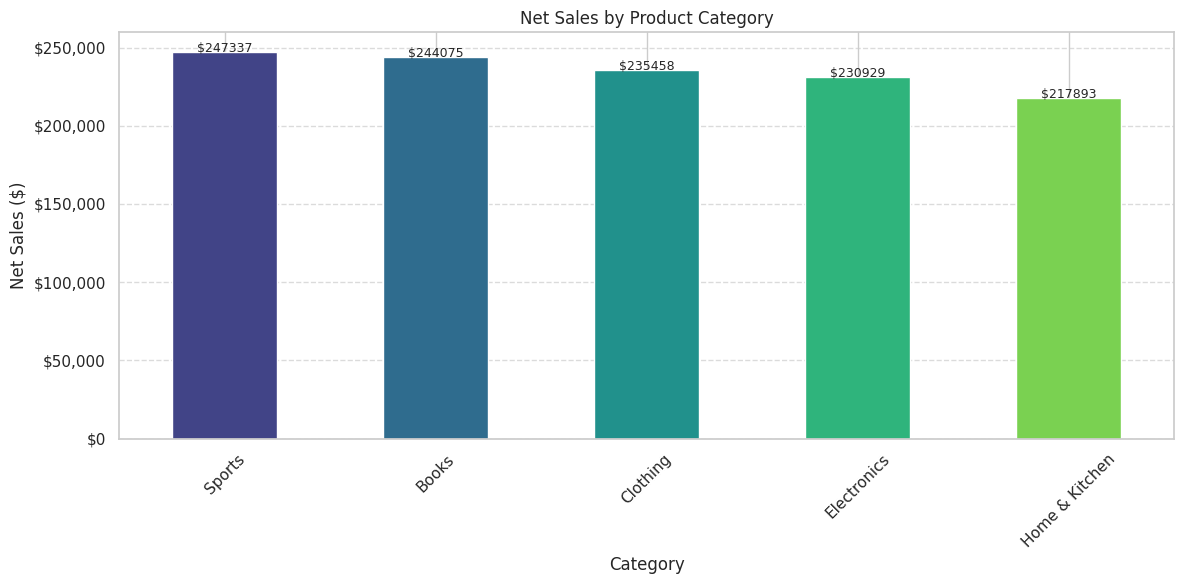

In [76]:
import matplotlib.ticker as mtick
# Set the default figure size 
plt.figure(figsize=(12, 6))
# 1. Bar chart: Sales by Category
sales_by_category = sales_df.groupby('Category')['Net_Sales'].sum().sort_values(ascending=False)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sales_by_category)))
ax = sales_by_category.plot(kind='bar', color=colors)
plt.title('Net Sales by Product Category')
plt.xlabel('Category')
plt.ylabel('Net Sales ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
for i, v in enumerate(sales_by_category):
    ax.text(i, v + 2, f'${v:.0f}', ha='center', fontsize=9)
plt.tight_layout() 
plt.show()


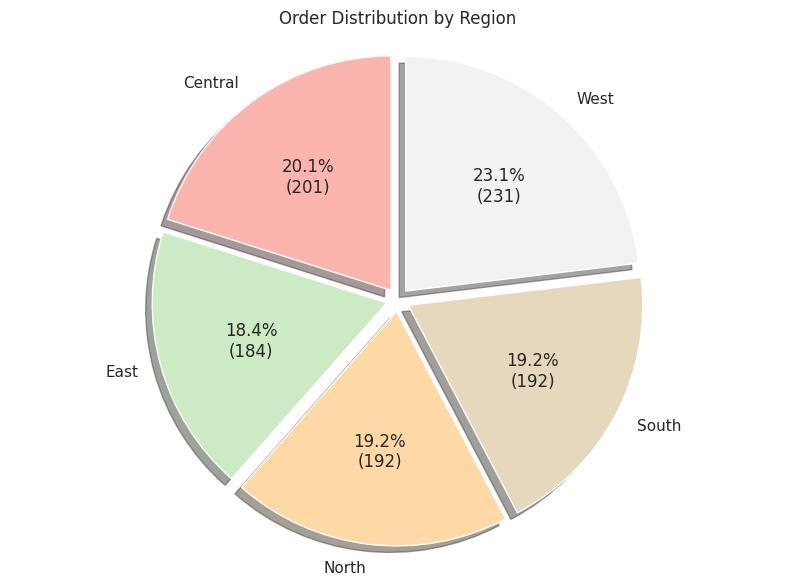

In [77]:
# 2. Pie chart: Order distribution by Region
'''
%1.1f%% to show percentage labels
explode=[0.05]*5 to pop out all slices
startangle=90 to rotate the pie
shadow=True for visual depth
'''
plt.figure(figsize=(10, 7))
orders_by_region = sales_df.copy().groupby('Region') ['Order_ID'].count()
def autopct_format(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return f"{pct:.1f}%\n({absolute})"
colors = plt.cm.Pastel1(np.linspace(0, 1, len(orders_by_region)))
plt.pie(
    orders_by_region,
    labels=orders_by_region.index,
    autopct=lambda pct: autopct_format(pct, orders_by_region),
    startangle=90,
    shadow=True,
    explode=[0.05] * len(orders_by_region),
    colors = colors
)
plt.title('Order Distribution by Region')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle 
plt.show()

In [78]:
sales_df.copy()

,Order_ID,Date,Category,Region,Customer_Segment,Payment_Method,Quantity,Unit_Price,Discount_Rate,Customer_Rating,Returned,Subcategory,Total_Price,Discount_Amount,Net_Sales,Shipping_Cost,Profit_Margin,Profit,Month,Year,Day,DayOfWeek,WeekOfYear
0,ORD-10000,2024-02-08 18:34:13.077410312,Books,East,Business,PayPal,1,316.58,0.20,5.0,False,Comics,316.58,63.32,253.26,0.00,0.33,83.58,2,2024,8,Thursday,6
1,ORD-10001,2024-10-07 10:33:01.033598332,Sports,West,Premium,Bank Transfer,5,279.76,0.10,4.0,True,Water Sports,1398.80,139.88,1258.92,0.00,0.20,251.78,10,2024,7,Monday,41
2,ORD-10002,2024-04-28 02:49:03.137408860,Home & Kitchen,Central,Business,Bank Transfer,6,209.61,0.05,4.0,False,Furniture,1257.66,62.88,1194.78,0.00,0.37,442.07,4,2024,28,Sunday,17
3,ORD-10003,2024-05-29 19:31:27.189540680,Home & Kitchen,North,Regular,Credit Card,3,265.47,0.15,4.0,False,Kitchenware,796.41,119.46,676.95,0.00,0.23,155.70,5,2024,29,Wednesday,22
4,ORD-10004,2024-09-15 06:43:38.505119780,Electronics,North,New,Bank Transfer,9,449.32,0.00,4.0,False,Accessories,4043.88,0.00,4043.88,0.00,0.37,1496.24,9,2024,15,Sunday,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ORD-10995,2024-07-16 02:21:20.263101390,Sports,North,New,PayPal,5,136.47,0.15,4.0,True,Team Sports,682.35,102.35,580.00,0.00,0.39,226.20,7,2024,16,Tuesday,29
996,ORD-10996,2024-12-13 07:00:55.475380576,Electronics,Central,Business,Credit Card,3,237.35,0.05,4.0,False,Audio,712.05,35.60,676.45,0.00,0.39,263.81,12,2024,13,Friday,50
997,ORD-10997,2024-07-07 11:14:35.719522450,Books,West,Premium,Cash on Delivery,1,75.31,0.10,2.0,False,Non-fiction,75.31,7.53,67.78,5.16,0.22,14.91,7,2024,7,Sunday,27
998,ORD-10998,2024-02-16 15:32:40.117101178,Clothing,South,New,Cash on Delivery,8,464.60,0.10,4.0,False,Accessories,3716.80,371.68,3345.12,0.00,0.39,1304.60,2,2024,16,Friday,7


In [79]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] 
orders_by_day = sales_df.copy().groupby('DayOfWeek')['Order_ID'].count().reindex (day_order) 
orders_by_day

DayOfWeek
Monday       157
Tuesday      126
Wednesday    136
Thursday     165
Friday       131
Saturday     143
Sunday       142
Name: Order_ID, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
orders_by_day = sales_df.copy().groupby('DayOfWeek')['Order_ID'].count().reindex(day_order)

plt.figure(figsize=(12, 6))
plt.plot(orders_by_day.index, orders_by_day.values, marker='o', linestyle='-', linewidth=2)

# Adjust vertical space with the text by adding offset (e.g., 5 units above the point)
for i, v in enumerate(orders_by_day):
    plt.text(i, v + 1.5, str(v), ha='center', fontsize=9)
'''
Argument	What It Does
i	        x-coordinate where the label is drawn (based on the category position)
v + 5	    y-coordinate 5 units above the point (creates vertical spacing)
str(v)	    The actual label text (converted from a number to a string)
ha='center'	Horizontal alignment of text — centers it over the x position i
fontsize=9	Controls the size of the text
'''
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Number of Orders by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()


In [ ]:
# 4. Box plot: Distribution of Net Sales by Category
# http://ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/data-presentation/box-and-whisker-plots.html
'''
 What a Boxplot Shows:
Minimum (excluding outliers)
First quartile (Q1) – 25th percentile
Median (Q2) – 50th percentile
Third quartile (Q3) – 75th percentile
Maximum (excluding outliers)
Outliers – data points outside 1.5×IQR range (displayed as dots)
'''
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='Category', y='Net_Sales', data=sales_df)

# Set plot title and labels
plt.title('Distribution of Net Sales by Product Category') 
plt.xlabel('Category')
plt.ylabel('Net Sales ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels for medians
medians = sales_df.groupby('Category')['Net_Sales'].median()
for i, category in enumerate(medians.index):
    median_val = medians[category]
    plt.text(i, median_val + 0.05 * median_val, f'${median_val:,.0f}', 
             ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 5. Heatmap: Correlation matrix
plt.figure(figsize=(12, 10))
corr_columns = ['Quantity', 'Unit_Price', 'Discount_Rate', 'Total_Price',
'Net_Sales', 'Profit', 'Customer_Rating']
corr_matrix = sales_df [corr_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5) 
plt.title('Correlation Matrix of Sales Metrics')
plt.tight_layout()
plt.show()

In [ ]:

# 6. Count plot: Customer Rating distribution by Category
# A count plot is a bar chart where the height of each bar represents the number of occurrences 
# of a category — perfect for categorical variables.
plt.figure(figsize=(14, 8))
ax = sns.countplot(x='Customer_Rating', hue='Category', data=sales_df) 
plt.title('Distribution of Customer Ratings by Category')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Category')
plt.grid(axis='y', linestyle='--', alpha=0.7) 

# 🔼 Add text labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Avoid showing text on bars with 0 height
        ax.text(p.get_x() + p.get_width()/2, # get x-position of text
                height + 1, # 1 unit point upper column
                int(height), # column hight
                ha='center', # center text horizontally
                fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:

# 7. Violin plot: Unit Price distribution by Category
'''
Combines a boxplot and KDE (kernel density estimate).
The plot shows:
Median (white dot): Trung vị (chấm trắng)
Interquartile range (thick bar in center) (IQR): Phạm vi liên tứ phân vị (thanh dày ở giữa)
Full distribution (violin shape): Phân phối đầy đủ (hình vĩ cầm)
The violin shape: Kernel Density Estimate (KDE), showing how data is spread.
Width of the violin: Proportional to the frequency of data points at that value.: Chiều rộng của vĩ cầm: Tỷ lệ thuận với tần suất các điểm dữ liệu tại giá trị đó.
'''
plt.figure(figsize=(14, 8))
sns.violinplot(x='Category', y='Unit_Price', data=sales_df) 
# sns.violinplot(x='Category', y='Unit_Price', data=sales_df, inner=None)  # Remove internal marks
# sns.stripplot(x='Category', y='Unit_Price', data=sales_df, color='black', size=2, jitter=True) # show the raw data distribution over the violin:
plt.title('Distribution of Unit Prices by Category')
plt.xlabel('Category')
plt.ylabel('Unit Price ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
medians = sales_df.groupby('Category')['Unit_Price'].median()
for i, (cat, med) in enumerate(medians.items()):
    plt.text(i, med + 2, f"${med:.2f}", ha='center', color='white', fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
pd.pivot_table(
data=sales_df,
values='Net_Sales',
index='Category',
columns='Region',
aggfunc='sum')

In [ ]:

# 8. Heatmap: Category vs Region Sales 
plt.figure(figsize=(14, 8))
pivot_table= pd.pivot_table(
data=sales_df,
values='Net_Sales',
index='Category',
columns='Region',
aggfunc='sum')
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5,  cbar_kws={'label': 'Net Sales ($)'}  )
'''
annot=True: shows the exact numbers in each cell.
fmt='.0f': formats them as whole numbers (no decimal).
cmap='YlGnBu': gives a yellow-green-blue gradient.
linewidths=0.5: separates the cells visually.
'''
plt.title('Net Sales by Category and Region')
plt.tight_layout()
plt.show()


In [ ]:
# 9. Pair plot of key metrics:  (scatterplot matrix) of key sales metrics using seaborn, which is great for visualizing relationships between multiple variables. 
plt.figure(figsize=(14, 8))
plot_df = sales_df [['Quantity', 'Unit_Price', 'Net_Sales', 'Profit', 'Customer_Rating']].sample(500) 
sns.pairplot (plot_df, diag_kind='kde') # Create pair plot with kernel density estimation on the diagonal
plt.suptitle('Pairwise Relationships Between Key Metrics', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# 10. Facet grid: Unit Price vs Quantity by Category
import numpy as np
plt.figure(figsize=(14, 8))
# Same FacetGrid setup
g = sns.FacetGrid(sales_df, col='Category', col_wrap=3, height=4, aspect=1.5)
g.map(sns.scatterplot, 'Unit_Price', 'Quantity', alpha=0.6)

# Add text to each subplot
for ax, category in zip(g.axes.flat, sales_df['Category'].unique()):
    sub_df = sales_df[sales_df['Category'] == category]
    mean_qty = sub_df['Quantity'].mean()
    ax.text(0.05, 0.95, f"Avg Qty: {mean_qty:.1f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=9, color='darkblue')

g.add_legend()
g.fig.suptitle('Unit Price vs Quantity by Category', y=1.03)
g.set_axis_labels('Unit Price ($)', 'Quantity')
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# FacetGrid: Unit Price vs Quantity by Category, with a regression line
g = sns.FacetGrid(sales_df, col='Category', col_wrap=3, height=4, aspect=1.5)
g.map(sns.regplot, 'Unit_Price', 'Quantity', scatter_kws={'alpha':0.6}, line_kws={'color': 'red', 'lw': 2})

# Add legend, title, and axis labels
g.add_legend()
g.fig.suptitle('Unit Price vs Quantity by Category with Regression Line', y=1.02)
g.set_axis_labels('Unit Price ($)', 'Quantity')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom order for the 'Category' facet titles (optional)
category_order = sales_df['Category'].unique()

# FacetGrid: Unit Price vs Quantity by Category, segmented by Category (using hue)
g = sns.FacetGrid(sales_df, col='Category', hue='Category', col_wrap=3, height=4, aspect=1.5, col_order=category_order)
g.map(sns.regplot, 'Unit_Price', 'Quantity', scatter_kws={'alpha':0.6}, line_kws={'color': 'red', 'lw': 2})

# Add legend, title, and axis labels
# g.add_legend(title='Category')
g.fig.legend(loc='upper left', bbox_to_anchor=(1.05, 0.5), title='Category', fontsize=10)
g.fig.suptitle('Unit Price vs Quantity by Category', y=1.02)
g.set_axis_labels('Unit Price ($)', 'Quantity')
# Move the legend to a custom position (e.g., outside the plot)

'''
g.fig.legend(loc='upper left', bbox_to_anchor=(1, 1), ...):
loc='upper left': Places the legend in the upper left of the plot (relative to the bbox_to_anchor).
bbox_to_anchor=(1, 1): Places the legend outside the plot area, at the top-right corner (relative to the figure’s dimensions).
You can modify bbox_to_anchor values to move the legend wherever you want, such as (0.5, 0.5) for the center of the plot or (1.05, 0.5) for outside, centered vertically.
'''
# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# FacetGrid with custom color palette and more control over title formatting
g = sns.FacetGrid(sales_df, col='Category', hue='Category', col_wrap=3, height=4, aspect=1.5, col_order=category_order, palette='Set2')
g.map(sns.regplot, 'Unit_Price', 'Quantity', scatter_kws={'alpha':0.8}, line_kws={'color': 'red', 'lw': 2})

# Add legend and title
# g.add_legend(title='Category')
g.fig.legend(loc='upper left', bbox_to_anchor=(1.05, 0.5), title='Category', fontsize=14)
# Move the legend to the bottom-center of the plot
# g.fig.legend(loc='center', bbox_to_anchor=(0.5, -0.1), title='Customer Type', fontsize=10)
# Or position it at the top-right corner, outside the plot
# g.fig.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Type', fontsize=10)
g.fig.suptitle('Unit Price vs Quantity by Category', y=1.02)
g.set_axis_labels('Unit Price ($)', 'Quantity')

# Adjust facet titles for better formatting
g.set_titles(col_template="{col_name}", size=12)

# Adjust layout
plt.tight_layout()
plt.show()


### Compare Sales_Data vs Data_Issues

In [ ]:
import pandas as pd
sales_data_sample_file_path = '/home/user/pandas-polar-dask/data/_1_bronze data/sales_data_sample.xlsx'


In [ ]:
sales_data = pd.read_excel(sales_data_sample_file_path, sheet_name='Sales_Data')
sales_data.head()

In [ ]:
# find columns have na value and count amount
sales_data.isna().sum().where(lambda x: x > 0).dropna().astype(int)

In [ ]:
# fill na values by mean
col_fill_na = ['Discount_Rate','Customer_Rating','Shipping_Cost']
sales_data[col_fill_na] = sales_data[col_fill_na].apply(lambda x: x.fillna(x.mean()),axis=0)

In [ ]:
pd.Series([1,None,2]).fillna(pd.Series([1,None,2]).mean())

In [ ]:
df_try = pd.DataFrame({'a': [1,None,2], 'b':[None,2,3]})
df_try[['a','b']] =  df_try[['a','b']].apply(lambda x: x.fillna(x.mean()),axis=0)
df_try

In [ ]:
sales_data.isna().sum().where(lambda x: x > 0).dropna().astype(int)

In [ ]:
any(sales_data.duplicated()) == True # all unique

In [ ]:
data_issues = pd.read_excel(sales_data_sample_file_path, sheet_name='Data_Issues')
data_issues.head()

In [ ]:
# find columns have na value and count amount
data_issues.isna().sum().where(lambda x: x > 0).dropna().astype(int)

In [ ]:
data_issues[data_issues['Date'].isna() | data_issues['Category'].isna() | data_issues['Region'].isna() | data_issues['Quantity'].isna() | data_issues['Discount_Rate'].isna() | data_issues['Customer_Rating'].isna() | data_issues['Shipping_Cost'].isna()].index

In [ ]:
any(data_issues.duplicated()) == True

In [ ]:
set(data_issues.columns) - set(sales_data.columns) # sales_data vs data_issues have same columns

In [ ]:
sales_data_has_issue = sales_data[sales_data['Order_ID'].isin(data_issues['Order_ID'])].reset_index(drop = True)
sales_data_has_issue

In [ ]:
sales_data_has_issue.sort_values('Order_ID', ascending = True, ignore_index = True, inplace = True)

In [ ]:
data_issues.sort_values('Order_ID', ascending = True, ignore_index = True, inplace = True)

In [ ]:
compare_data_issue = sales_data_has_issue.compare(data_issues, result_names=('Sales_Data', 'Data_Issue'))

order_id_compared = sales_data_has_issue.loc[sales_data_has_issue.index.isin(compare_data_issue.index), 'Order_ID']
compare_data_issue.insert(0, 'Order_ID', value = order_id_compared, )
compare_data_issue

In [ ]:
def highlight(row):
    return np.where(row.notna(),'background-color: lightblue', '')
import numpy as np


In [ ]:
compare_data_issue_hightlight = compare_data_issue.style.highlight_null('lightgray')
# apply(highlight, axis =0)
compare_data_issue_hightlight

In [ ]:
compare_data_issue.index 

In [ ]:
data_issues[data_issues.index.isin(compare_data_issue.index )] = sales_data_has_issue[sales_data_has_issue.index.isin(compare_data_issue.index )]

In [ ]:
# find columns have na value and count amount
data_issues.isna().sum().where(lambda x: x > 0).dropna().astype(int)

In [ ]:
sales_data['Is_Issued'] = sales_data['Order_ID'].apply(lambda x: x in data_issues['Order_ID'].values)
sales_data.head()

In [ ]:
sales_data.info()

In [ ]:
# Category has issue
cate_vs_sub_has_issue = sales_data[sales_data['Is_Issued'] == True].groupby(['Category']).agg({'Is_Issued': 'sum'})
cate_vs_sub_has_issue.rename(columns = {'Is_Issued': 'Num_of_data'}, inplace = True)
cate_vs_sub_has_issue.sort_values(by = 'Num_of_data', ascending = True, inplace = True)
cate_vs_sub_has_issue.reset_index(inplace = True)
cate_vs_sub_has_issue

In [ ]:
# plot chart num of data issue by category
import altair as alt

# Create bar chart with Altair
chart = alt.Chart(cate_vs_sub_has_issue).mark_bar(color='steelblue').encode(
    x=alt.X('Category:N', title='Category', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Num_of_data:Q', title='Num of data'),
    color=alt.Color('Category:N'),  
    tooltip=['Category', 'Num_of_data']
).properties(
    title='Num of data has issue by Category',
    width=500,  # 🔹 Set chart width
    height=300
)
# Text labels on top of bars
text = alt.Chart(cate_vs_sub_has_issue).mark_text(
    align='center',
    baseline='bottom',
    dy=-5,  # move text 5px above the bar
    fontSize=12
).encode(
    x='Category:N',
    y='Num_of_data:Q',
    text='Num_of_data:Q'
)

# Combine chart and text
chart = chart + text
chart.properties(title='Num_of_data').configure_axis(labelFontSize=12, titleFontSize=14)
chart.display()


In [ ]:
sales_data_issued = sales_data[sales_data['Is_Issued'] == True].reset_index(drop = True)

In [ ]:
# Month has data issue
data_issues_per_month = sales_data_issued.groupby('Month').agg({'Is_Issued': 'count'}).reset_index()
data_issues_per_month.rename({"Is_Issued": 'Num_Of_Data'}, axis =1, inplace = True)
data_issues_per_month

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(data_issues_per_month['Month'], data_issues_per_month['Num_Of_Data'], color='lightblue', width=0.3)
for i,v in enumerate(data_issues_per_month['Num_Of_Data']):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.title('Num of data issues per month')
plt.xlabel('Month')
plt.ylabel('Num of data')
plt.grid(True, linestyle = '--', color = 'gray', alpha = 0.3)
plt.show()

In [ ]:
# Net_Sales	Profit_Margin	Profit per month
profit_per_month = sales_data_issued.groupby('Month').agg({'Net_Sales': 'sum', 'Profit_Margin': 'mean', 'Profit': 'sum'}).round(2).reset_index()
profit_per_month

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(profit_per_month['Month'], profit_per_month['Net_Sales'], color='tomato', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='tomato', markersize=12)
plt.plot(profit_per_month['Month'], profit_per_month['Profit'], color='lightblue', linestyle='dashed', linewidth = 2,
         marker='o', markerfacecolor='lightblue', markersize=12)
# for i,v in enumerate(profit_per_month['Profit']):
#     plt.text(i, v + 5, str(v), ha='center', )
# for i,v in enumerate(profit_per_month['Net_Sales']):
#     plt.text(i, v + 2, str(v), ha='center')
plt.fill_between(profit_per_month['Month'], profit_per_month['Net_Sales'], profit_per_month['Profit'],  color='grey', alpha=0.1)
plt.grid(True, linestyle = '--', color = 'gray', alpha = 0.3)
plt.xlabel("Month")  # add X-axis label
plt.ylabel("Amount")  # add Y-axis label
plt.title("Net sale and Profit per month")  # add title
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(profit_per_month['Month'], profit_per_month['Profit_Margin'], color='green', linestyle='-', linewidth = 1,
          markerfacecolor='green')
# for i,v in enumerate(profit_per_month['Profit_Margin']):
#     plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.grid(True, linestyle = '--', color = 'gray', alpha = 0.3)
plt.show()

In [ ]:
sales_data.head()

In [ ]:
#Category amount per month
cate_sale_per_month = pd.crosstab(index = sales_data['Month'], columns = sales_data['Category'], values = sales_data['Quantity'], aggfunc= 'sum')
cate_sale_per_month = cate_sale_per_month.fillna(0).astype(int)
cate_sale_per_month

In [ ]:
sales_data[sales_data['Month'] == '2025-04']

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(cate_sale_per_month, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Category sales per month')
plt.xlabel('Category')
plt.ylabel('Month')
plt.show()

In [ ]:
sns.color_palette()


In [ ]:
# stacked bar
cate_sale_per_month.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Paired', alpha = 0.8)
plt.title('Category sales per month')
plt.xlabel('Month', labelpad=15)
plt.ylabel('Amount')
plt.legend(title='Category')
plt.grid(True, linestyle='--', color='lightgray')
plt.show()

In [ ]:
# grouped bar chart
cate_sale_per_month.plot(kind='bar', stacked=False, figsize=(12, 7), colormap='Paired', width = .5)
plt.title('Category sales per month')
plt.xlabel('Month', labelpad=15)
plt.ylabel('Amount')
plt.legend(title='Category')
plt.grid(True, linestyle='--', color='lightgray')
plt.show()

In [ ]:
sales_data.head()

In [ ]:
# region vs Customer_Segment
customer_segment_per_region = pd.crosstab(index = sales_data['Region'], columns = sales_data['Customer_Segment'], normalize = 'index') *100
customer_segment_per_region = customer_segment_per_region.round(2)
customer_segment_per_region

In [ ]:
# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()  # Flatten to 1D array for easy looping

# Colors
colors = plt.cm.Set1.colors

# Plot each region
for i, region in enumerate(customer_segment_per_region.index):
    values = customer_segment_per_region.loc[region]
    labels = values.index
    axes[i].pie(
        values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.05] * len(labels),
        colors=colors
    )
    axes[i].set_title(f"{region} Region", fontsize=14)
    axes[i].axis('equal')

# Hide any empty subplots (since we have 6 slots but only 5 regions)
for j in range(len(customer_segment_per_region.index), len(axes)):
    fig.delaxes(axes[j])

# Set overall title
plt.suptitle('Customer Segment Distribution by Region', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Sum across regions
total = sales_data['Customer_Segment'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
plt.pie(total, labels=total.index, autopct='%1.1f%%', startangle=90, shadow=True, explode=[0.05]*4, colors=plt.cm.Pastel1.colors)
plt.title('Overall Customer Segment Distribution')
plt.axis('equal')
plt.show()


In [ ]:
# sales_data index /col:  'Category', 'Subcategory', 'Region', 'Customer_Segment','Payment_Method', 'Month'
# value explode: 'Quantity', 'Unit_Price', 'Discount_Rate', 'Customer_Rating', 'Returned', 'Total_Price',  'Discount_Amount', 'Net_Sales', 'Shipping_Cost', 'Profit_Margin',  'Profit', 'Is_Issued'
# can explode value/info base on indexes/cols above and among index/cols
# category best seller
# regions purchase the most
# quantity per month,..
# profit per month
# net_sales vase on category and customer segment
# .....
sales_data.columns

In [ ]:
customer_data = pd.read_excel(sales_data_sample_file_path, sheet_name='Customer_Data')
customer_data.head()

In [ ]:
# ratio of gender/age-group purchases
# the most used device/ browserused for purchasing 
# first purchase ratio of per month/category, based on age group, gender, which cate in first purchase, payment method used for first purchase, ....
# /cate/subcate/product ... purschased basd on gender, age group,...
# khai thac hanh vi tieu dung, thoi quan mua sam, thanh toan

In [ ]:
customer_data.info()

In [ ]:
# product 
# whic cate is most at aspect: quantity, price, cost, returned, first purchase, rating num of customer, gender, age, region, 
# supplier supply most? and which cate? 
# lead time day(g tu khi dat hang den khi nhan hang, bao gom tg van chuyen,...) which cate is shortest, longest, avg
# relation bw returned vs customer rating, lead_time_day, age group, gender, cate ? , cost, affect on profit, net_sale,...
# stock level(so luong hang con trong kho) => relates to num of product sale, profit,discount,..
# reorder level(han muc so luong ha g con lai, dung de xac dinh khi nao can phai dat hang them, vs reorder level = 30, nghia la khi hang con trong kho laf 30 sp thi can phai dat hang them ve)
# muc tieu thu hang hoa hang thang, thi hang trong kho co du cung cap ko, neu fai dat hang thif so hang trong kho co du dung trong luc cho doi nha cung cap ca hang ko? VD kho co 100 sp, moi ngay cos 10 sp ban ra thi hoi luc nao can phai dat hang de ban, vs tg lead time day = 15 ngay ? gia su hang ve vua luc kho cham muc reorder level?/ het hang ? hoac la vs muc reorder level do thi co kip hang ve ko? hoac tinh lai muc reorder level? thoi die dat hang lai cho moi mat hang hang thag ...abs

In [ ]:
sales_data_new = pd.read_excel(sales_data_sample_file_path, sheet_name = 'Sales_Data')

In [ ]:
discount_rate_calc = (sales_data_new['Discount_Amount']/ sales_data_new['Total_Price']).round(2)
discount_compare = discount_rate_calc.compare(sales_data_new['Discount_Rate'].round(2), result_names=('Calc','Origin'))
discount_compare.insert(0, 'Order_ID', sales_data_new.loc[sales_data.index.isin(discount_compare.index),'Order_ID'])
discount_compare